In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio

import sys
sys.path.append('../../tools/')
import fitting_functions

import matplotlib.colors
import matplotlib.ticker as ticker

In [3]:
# Load R interface to do statistics
import rpy2.rinterface
%load_ext rpy2.ipython

In [2]:
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2
            for (c1, c2) in zip(rgb, bg_rgb)]

# red_l = make_rgb_transparent(matplotlib.colors.to_rgb('C3'), (1, 1, 1), 0.5) + [1,]
red_l2 = make_rgb_transparent(matplotlib.colors.to_rgba(plt.rcParams['axes.prop_cycle'].by_key()['color'][3])[:-1], (1, 1, 1), 0.75) + [1,]
red_l3 = make_rgb_transparent(matplotlib.colors.to_rgba(plt.rcParams['axes.prop_cycle'].by_key()['color'][3])[:-1], (1, 1, 1), 0.5) + [1,]

In [3]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [4]:
def prepareStepResponse(filename, num_components_extrap = 2, conservative=False):
    trange, eye_pos, pe_start_index, displacement_index, release_index, step_pos = fitting_functions.importActiveData('../../data/active/fixed/'+filename+'.mat')

    fish_name = filename[:-5]
    if conservative:
        filename += "_conservative"
        fish_name += "_conservative"
        conservative_file = sio.loadmat('extrap/results/'+filename+'.mat')
        conservative_fit = conservative_file['fit'][0]
        extrap = fitting_functions.exponentialModel(trange, conservative_fit)*eye_pos[0]
    else:
        extrap_file = sio.loadmat('extrap/results/'+filename +'.mat')
        lls = extrap_file['lls']
        fits_extrap = extrap_file['fits']
        best_fit_ind = np.argmax(lls[num_components_extrap-1,:])
        extrap = fitting_functions.exponentialModel(trange, fits_extrap[num_components_extrap-1,0][best_fit_ind,:])*eye_pos[0]

    sr_data = extrap[release_index:] -  eye_pos[release_index:]
    sr_trange = trange[release_index:] - trange[release_index]

    return sr_trange, sr_data

In [5]:
def R2(data,fit):
    try:
        x = data.shape[0]
        sstot = np.sum((fit - np.mean(data))**2)
        sse = np.sum((fit - data)**2)
    except:
        sstot = np.sum([np.sum((fit[i] - np.mean(data[i]))**2) for i in range(len(data))])
        sse = np.sum([np.sum((fit[i] - data[i])**2) for i in range(len(data))])
    return 1-sse/sstot

In [6]:
file_names = [('090711e_0006',), ('090811c_0002',), ('090811d_0002','090811d_0004',),
   ('091111a_0001', '091111a_0003'), ('091111c_0003',), ('091211a_0002', '091211a_0005')]

In [7]:
max_num_components = 6

# Fit quality

In [8]:
best_num_components_extrap = {'090711e_0006':2, '090811c_0002':2, '090811d_0002':2, '090811d_0004':2,'091111a_0001':2,
                    '091111a_0003':3,'091111c_0003':2,'091211a_0002':2,'091211a_0005':2}

In [9]:
# Best extrapolations
mses_best = np.zeros((len(file_names), max_num_components))
# Conservative extrapolations
mses_conservative = np.zeros((len(file_names), max_num_components))

for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    
    
    fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
    lls_original = fit_file_original['lls']
    fits_original = fit_file_original['fits']
    best_trace_inds = np.argmax(lls_original, axis=1)
    
    for j in range(max_num_components):
        for i in range(len(file_names[fish_num])):
            n = best_num_components_extrap[file_names[fish_num][i]]
            sr_trange, sr_data = prepareStepResponse(file_names[fish_num][i], num_components_extrap = n)
            best_fit = fits_original[j,i][best_trace_inds[j],:]
            sse_fit = np.sum((sr_data/sr_data[0] - fitting_functions.exponentialModel(sr_trange, best_fit))**2)
            mses_best[fish_num,j] += sse_fit/len(sr_trange)
    mses_best[fish_num,j] /= len(file_names[fish_num])
    
    fit_file_conservative = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
    lls_conservative = fit_file_conservative['lls']
    fits_conservative = fit_file_conservative['fits']
    best_trace_inds_conservative = np.argmax(lls_conservative, axis=1)
    for j in range(max_num_components):
        for i in range(len(file_names[fish_num])):
            n = best_num_components_extrap[file_names[fish_num][i]]
            sr_trange, sr_data = prepareStepResponse(file_names[fish_num][i], num_components_extrap=n, conservative=True)
            best_fit = fits_conservative[j,i][best_trace_inds_conservative[j],:]
            sse_fit = np.sum((sr_data/sr_data[0] - fitting_functions.exponentialModel(sr_trange, best_fit))**2)
            mses_conservative[fish_num,j] += sse_fit/len(sr_trange)
    mses_conservative[fish_num,j] /= len(file_names[fish_num])

In [10]:
mse_pct_change = (mses_best[:, 1:] - mses_best[:, :-1])/mses_best[:, :-1]
mse_pct_change_conservative = (mses_conservative[:, 1:] - mses_conservative[:, :-1])/mses_conservative[:, :-1]

## Figure 4C: MSE vs num of components

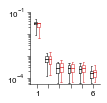

In [44]:
plt.figure(figsize=(1.3, 1.3))

## Mean squared error
ax = plt.gca()
ax.set_yscale('log')

plt.boxplot(mses_best, positions=np.arange(1,7)-0.15, whis=(0,100), widths=0.25, medianprops={'c':'k', 'linewidth':0.75},
            boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, capprops={'linewidth':0.5});
plt.boxplot(mses_conservative, positions=np.arange(1,7)+0.15, whis=(0,100), widths=0.25, 
            medianprops={'c':'C3', 'linewidth':0.75},
            boxprops={'c':'C3','linewidth':0.5}, whiskerprops={'c':'C3','linewidth':0.5}, 
            capprops={'c':'C3','linewidth':0.5});

plt.ylim([5e-5, 1e-1])
locmin = matplotlib.ticker.LogLocator(base=10.0,subs='all',numticks=5)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
ax.set_yticklabels([r'$10^{-4}$', '', '', r'$10^{-1}$'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(1,7), ['1','','','','','6'])

plt.subplots_adjust(left = 0.23, top = 0.95, bottom=0.18, right=0.98)

## Figure 4C: %change in MSE

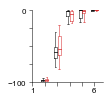

In [22]:
plt.figure(figsize=(1.3, 1.3))

## Mean squared error
ax = plt.gca()

plt.boxplot(mse_pct_change, positions=np.arange(2,7)-0.15, whis=(0,100), widths=0.25, medianprops={'c':'k', 'linewidth':0.75},
            boxprops={'linewidth':0.5}, whiskerprops={'linewidth':0.5}, capprops={'linewidth':0.5});
plt.boxplot(mse_pct_change_conservative, positions=np.arange(2,7)+0.15, whis=(0,100), widths=0.25, 
            medianprops={'c':'C3', 'linewidth':0.75},
            boxprops={'c':'C3','linewidth':0.5}, whiskerprops={'c':'C3','linewidth':0.5}, 
            capprops={'c':'C3','linewidth':0.5});

plt.ylim([-1, 0])
ax.set_yticks(np.linspace(-1, 0, 5))
ax.set_yticklabels([r'$-100$', '', '', '',r'$0$'])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(np.arange(1,7), ['1','','','','','6'])

plt.subplots_adjust(left = 0.23, top = 0.95, bottom=0.18, right=0.98)

## For individual fish
### Best extrapolation

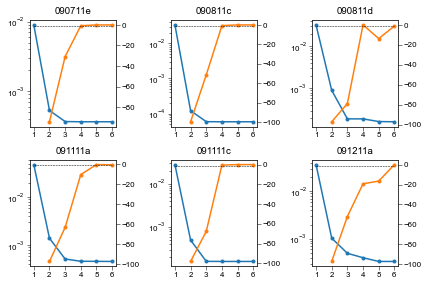

In [23]:
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]

    plt.subplot(2,3,fish_num+1)
    plt.title(fish_name)
    plt.yscale('log')
    plt.plot(np.arange(1,7), mses_best[fish_num,:],'.-')
    ax = plt.twinx()
    # ax.set_yscale('log')
    ax.plot(np.arange(2,7), (mses_best[fish_num,1:]-mses_best[fish_num,:-1])/mses_best[fish_num,:-1]*100,'.-', c='C1')
    ax.plot([1, 6], [-1, -1], 'k--', lw=0.5)
    plt.xticks(np.arange(1,7))
plt.tight_layout()

In [11]:
best_num_components = {'090711e':3, '090811c':3, '090811d':3, '091111a':4, '091111c':3, '091211a':3}

To determine the number of components to use, we looked for the elbow in the %change in MSE after which error did not decrease with increasing number of components. 

For fish 091211a, we used 3 components, as after this point, there would be a zero component for the fits to one of the two responses.

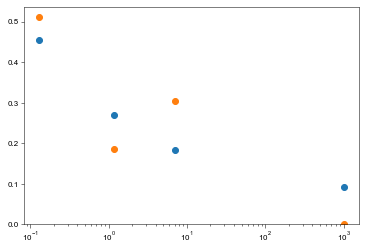

In [38]:
fish_num = 5
fish_name = file_names[fish_num][0][:-5]


fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
lls_original = fit_file_original['lls']
fits_original = fit_file_original['fits']
best_trace_inds = np.argmax(lls_original, axis=1)

n = 4
timeconstants = 1/np.maximum(1e-3, fits_original[n-1,0][best_trace_inds[n-1],n:])
# Time constant 10^3 -> infinity
c1 = fits_original[n-1,0][best_trace_inds[n-1],:n]
c2 = fits_original[n-1,1][best_trace_inds[n-1],:n]
plt.xscale('log')
plt.scatter(timeconstants, c1)
plt.scatter(timeconstants, c2)
plt.ylim([0, plt.ylim()[1]]);

### Conservative extrapolation

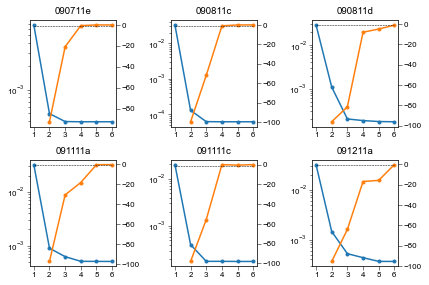

In [30]:
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]

    plt.subplot(2,3,fish_num+1)
    plt.title(fish_name)
    plt.yscale('log')
    plt.plot(np.arange(1,7), mses_conservative[fish_num,:],'.-')
    ax = plt.twinx()
    # ax.set_yscale('log')
    ax.plot(np.arange(2,7), (mses_conservative[fish_num,1:]-mses_conservative[fish_num,:-1])/mses_conservative[fish_num,:-1]*100,'.-', c='C1')
    ax.plot([1, 6], [-1, -1], 'k--', lw=0.5)
    plt.xticks(np.arange(1,7))
plt.tight_layout()

In [12]:
best_num_components_conservative = {'090711e':3, '090811c':3, '090811d':4, '091111a':4, '091111c':3, '091211a':3}

As above, fish 091211a had a zero component in the fit to one of the traces for ≥4 components.

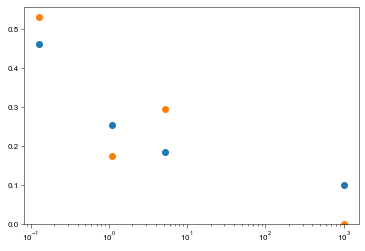

In [39]:
fish_num = 5
fish_name = file_names[fish_num][0][:-5]


fit_file_conservative = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
lls_conservative = fit_file_conservative['lls']
fits_conservative = fit_file_conservative['fits']
best_trace_inds_conservative = np.argmax(lls_conservative, axis=1)

n = 4
timeconstants = 1/np.maximum(1e-3, fits_conservative[n-1,0][best_trace_inds_conservative[n-1],n:])
# Time constant 10^3 -> infinity
c1 = fits_conservative[n-1,0][best_trace_inds_conservative[n-1],:n]
c2 = fits_conservative[n-1,1][best_trace_inds_conservative[n-1],:n]
plt.xscale('log')
plt.scatter(timeconstants, c1)
plt.scatter(timeconstants, c2)
plt.ylim([0, plt.ylim()[1]]);

# Parameter summaries

## Best 3 component models (in text)

In [41]:
best_fits = np.zeros((9, max_num_components))
timeconstants_unique = np.zeros((len(file_names), 3))
j = 0
n = 3
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
    lls_original = fit_file_original['lls']
    fits_original = fit_file_original['fits']
    best_trace_ind = np.argmax(lls_original[n-1, :])
    
    for i in range(len(file_names[fish_num])):
        best_fit = fits_original[n-1, i][best_trace_ind, :]
        best_fits[j,:] = fits_original[n-1, i][best_trace_ind, :]
        j += 1
    timeconstants_unique[fish_num,:] = fits_original[n-1, i][best_trace_ind, 3:]

In [42]:
best_fits_conservative = np.zeros((9, max_num_components))
timeconstants_unique_conservative = np.zeros((len(file_names), 3))
j = 0
n=3
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    fit_file_original = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
    lls_original = fit_file_original['lls']
    fits_original = fit_file_original['fits']
    best_trace_ind = np.argmax(lls_original[n-1, :])
    
    # plt.subplot(2,3,fish_num+1)
    for i in range(len(file_names[fish_num])):
        best_fit = fits_original[n-1, i][best_trace_ind, :]
        # timeconstants = np.minimum(1/best_fit[-n:], 1e3 )
        best_fits_conservative[j,:] = fits_original[n-1, i][best_trace_ind, :]
        j += 1
    timeconstants_unique_conservative[fish_num,:] = fits_original[n-1, i][best_trace_ind, 3:]

In [45]:
## Best extrap
with np.errstate(divide='ignore'):
    print("25%ile:", np.percentile(1/timeconstants_unique, 25, axis=0))
    print("Median:", np.median(1/timeconstants_unique, axis=0))
    print("75%ile:", np.percentile(1/timeconstants_unique, 75, axis=0))

25%ile: [ 0.13077673  1.91054113 30.75308212]
Median: [ 0.17027792  2.5223347  38.78140219]
75%ile: [0.2266596  2.72392355        inf]


In [46]:
## Conservative
with np.errstate(divide='ignore'):
    print("25%ile:", np.percentile(1/timeconstants_unique_conservative, 25, axis=0))
    print("Median:", np.median(1/timeconstants_unique_conservative, axis=0))
    print("75%ile:", np.percentile(1/timeconstants_unique_conservative, 75, axis=0))

25%ile: [ 0.13051986  1.58234041 16.76520481]
Median: [ 0.17200786  2.18824734 22.26353717]
75%ile: [0.19324621 2.64756824        inf]


## Mixed 3/4 tau models (to plot)

In [47]:
best_fits_3 = np.zeros((sum([best_num_components[file_names[i][j][:-5]] == 3 for i in range(len(file_names)) for j in range(len(file_names[i]))]), 6))
best_fits_4 = np.zeros((sum([best_num_components[file_names[i][j][:-5]] == 4 for i in range(len(file_names)) for j in range(len(file_names[i]))]), 8))

j3 = 0
j4 = 0
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components[fish_name]
    fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
    lls_original = fit_file_original['lls']
    fits_original = fit_file_original['fits']
    best_trace_ind = np.argmax(lls_original[n-1, :])
    
    for i in range(len(file_names[fish_num])):
        best_fit = fits_original[n-1, i][best_trace_ind, :]
        sort_order = np.flip(np.argsort(best_fit[n:]))
        coeffs = best_fit[sort_order]
        taus = best_fit[n+sort_order]
        if n == 4:
            best_fits_4[j4, :] = np.concatenate((coeffs, taus))
            j4 += 1
        else:
            best_fits_3[j3, :] = np.concatenate((coeffs, taus))
            j3+= 1

In [48]:
best_fits_3_conservative = np.zeros((sum([best_num_components_conservative[file_names[i][j][:-5]] == 3 for i in range(len(file_names)) for j in range(len(file_names[i]))]), 6))
best_fits_4_conservative = np.zeros((sum([best_num_components_conservative[file_names[i][j][:-5]] == 4 for i in range(len(file_names)) for j in range(len(file_names[i]))]), 8))

j3 = 0
j4 = 0
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components_conservative[fish_name]
    fit_file_original = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
    lls_original = fit_file_original['lls']
    fits_original = fit_file_original['fits']
    best_trace_ind = np.argmax(lls_original[n-1, :])
    
    for i in range(len(file_names[fish_num])):
        best_fit = fits_original[n-1, i][best_trace_ind, :]
        sort_order = np.flip(np.argsort(best_fit[n:]))
        coeffs = best_fit[sort_order]
        taus = best_fit[n+sort_order]
        if n == 4:
            best_fits_4_conservative[j4, :] = np.concatenate((coeffs, taus))
            j4 += 1
        else:
            best_fits_3_conservative[j3, :] = np.concatenate((coeffs, taus))
            j3+= 1

## Figure 4E: parameter summary for best extrapolation

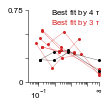

In [49]:
plt.figure(figsize=(1.3, 1.3))
plt.xscale('log')


for i in range(best_fits_3.shape[0]):
    plt.plot(1/np.maximum(best_fits_3[i, 3:], 1/5e2), best_fits_3[i, :3], '.-', lw=0.25, ms=4, c='C3', clip_on=False) 
for i in range(best_fits_4.shape[0]):
    plt.plot(1/np.maximum(best_fits_4[i, 4:], 1/5e2), best_fits_4[i, :4], '.-', lw=0.25, ms=4, c='k', clip_on=False)   

plt.ylim([0, 0.75])
plt.xlim([0.25e-1, 3e2])
ax = plt.gca()
ax.set_yticks(np.linspace(0,0.75,4))
ax.set_yticklabels([0, '','',0.75])

locmin = matplotlib.ticker.LogLocator(base=10.0,subs='all',numticks=5)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1e-1, 1e0, 1e1, 1e2, 5e2])
ax.set_xticklabels([r'$10^{-1}$', '', '', '', r'$\infty$']);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.figtext(0.97, 0.9, r'Best fit by 4 $\tau$', color='k', horizontalalignment='right')
plt.figtext(0.97, 0.8, r'Best fit by 3 $\tau$', color='C3', horizontalalignment='right')

plt.subplots_adjust(left = 0.21, top = 0.95, bottom=0.18, right=0.96)

## Figure 4F: parameter summary for conservative extrapolation

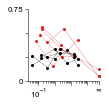

In [51]:
plt.figure(figsize=(1.3, 1.3))
plt.xscale('log')

for i in range(best_fits_3_conservative.shape[0]):
    plt.plot(1/np.maximum(best_fits_3_conservative[i, 3:], 1/5e2), best_fits_3_conservative[i, :3], '.-', lw=0.25, ms=4, c='C3', clip_on=False) 
for i in range(best_fits_4_conservative.shape[0]):
    plt.plot(1/np.maximum(best_fits_4_conservative[i, 4:], 1/5e2), best_fits_4_conservative[i, :4], '.-', lw=0.25, ms=4, c='k', clip_on=False)   

plt.ylim([0, 0.75])
plt.xlim([0.25e-1, 3e2])
ax = plt.gca()
ax.set_yticks(np.linspace(0,0.75,4))
ax.set_yticklabels([0, '','',0.75])

locmin = matplotlib.ticker.LogLocator(base=10.0,subs='all',numticks=5)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.set_xticks([1e-1, 1e0, 1e1, 1e2, 5e2])
ax.set_xticklabels([r'$10^{-1}$', '', '', '', r'$\infty$']);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.subplots_adjust(left = 0.21, top = 0.95, bottom=0.18, right=0.96)

# Example traces

In [16]:
dt = 72*2e-4

In [39]:
example_fish = 4
example_trace_num = np.minimum(0, len(file_names[example_fish])-1)
example_trace = file_names[example_fish][example_trace_num]
fish_name = example_trace[:-5]
n = best_num_components[fish_name] # 3
n_conservative = best_num_components_conservative[fish_name] 

### Best extrapolation
# Import data
sr_trange, sr_data = prepareStepResponse(example_trace, num_components_extrap = best_num_components_extrap[example_trace])

sr_trange_full = np.arange(0, int(sr_trange[-1]/dt))*dt

# Import fit
fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
lls_original = fit_file_original['lls']
fits_original = fit_file_original['fits']
best_trace_ind = np.argmax(lls_original, axis=1)

best_fit_3 = fits_original[n-1, example_trace_num][best_trace_ind[n-1], :]
best_fit_2 = fits_original[1, example_trace_num][best_trace_ind[1], :]
best_fit_1 = fits_original[0, example_trace_num][best_trace_ind[0], :]

# Fit constrained to have tau < 5 s
fit_file_original_bounded = sio.loadmat('fit/results/best/'+fish_name+'_5s.mat')
lls_original_bounded = fit_file_original_bounded['lls']
fits_original_bounded = fit_file_original_bounded['fits']
best_trace_ind = np.argmax(lls_original_bounded, axis=1)

best_fit_ = fits_original_bounded[n-1, example_trace_num][best_trace_ind[n-1], :]

best_models_example = np.zeros((4, len(sr_trange_full)))
best_models_example[0,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_1)
best_models_example[1,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_)
best_models_example[2,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_2)
best_models_example[3,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_3)

    
### Conservative extrapolation
sr_trange_conservative, sr_data_conservative = prepareStepResponse(example_trace, conservative=True)

fit_file_conservative = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
lls_conservative = fit_file_conservative['lls']
fits_conservative = fit_file_conservative['fits']
best_trace_ind_conservative = np.argmax(lls_conservative, axis=1)

best_fit_3 = fits_conservative[n_conservative, example_trace_num][best_trace_ind_conservative[n_conservative-1], :]
best_fit_2 = fits_conservative[1, example_trace_num][best_trace_ind_conservative[1], :]
best_fit_1 = fits_conservative[0, example_trace_num][best_trace_ind_conservative[0], :]

fit_file_conservative_bounded = sio.loadmat('fit/results/conservative/'+fish_name+'_5s_conservative.mat')
lls_conservative_bounded = fit_file_conservative_bounded['lls']
fits_conservative_bounded = fit_file_conservative_bounded['fits']
best_trace_ind = np.argmax(lls_conservative_bounded, axis=1)

best_fit_ = fits_conservative_bounded[n-1, example_trace_num][best_trace_ind[n-1], :]

best_models_conservative_example = np.zeros((4, len(sr_trange_full)))
best_models_conservative_example[0,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_1)
best_models_conservative_example[1,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_)
best_models_conservative_example[2,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_2)
best_models_conservative_example[3,:] = fitting_functions.exponentialModel(sr_trange_full, best_fit_3)



In [28]:
t_final_example_full = int(2/dt)

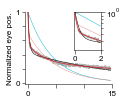

In [44]:
plt.figure(figsize=(1.5, 1.3))
plt.plot(sr_trange[1:], sr_data[1:]/sr_data[0], c=[0.7,]*3,lw=1)

lws = [0.5, 0.5, 0.5, 0.75]
colors = ['C9', red_l3, 'k', 'C3']
for i in range(4):
    plt.plot(sr_trange_full, best_models_example[i,:], c=colors[i], lw=lws[i])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Normalized eye pos.',labelpad=2)
plt.subplots_adjust(left = 0.21, top = 0.95, bottom=0.18, right=0.98)

ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([0, '', '', '', '', 1])
plt.ylim([-0.02, 1])
plt.xlim([-0.5, np.ceil(sr_trange[-1])])

ax.set_xticks(np.linspace(0, np.ceil(sr_trange[-1]),4))
ax.set_xticklabels([0, '', '', int(np.ceil(sr_trange[-1]))])


# plt.figtext(0.95, 0.85, r'%d $\tau$ fit, $\tau < \infty$'%(n), color='C3', ha='right')
# plt.figtext(0.95, 0.75, r'%d $\tau$ fit, $\tau < 5$ s'%(n), color=red_l3, ha='right')
# plt.figtext(0.95, 0.65, r'2 $\tau$ fit', color='k', ha='right')
# plt.figtext(0.95, 0.55, r'1 $\tau$ fit', color='C9', ha='right')

ax1 = plt.axes([.6, .55, 0.25, .4])
plt.yscale('log')
plt.plot(sr_trange[1:t_final_example_full], sr_data[1:t_final_example_full]/sr_data[0], c=[0.7,]*3,lw=1)
for i in range(4):
    plt.plot(sr_trange_full[:t_final_example_full], best_models_example[i,:t_final_example_full], c=colors[i], lw=lws[i])


ax1.set_ylim([3e-1, 1])
ax1.set_xlim([-0.1, 2])
ax1.set_yticklabels([],minor=True)
ax1.yaxis.tick_right()

plt.subplots_adjust(left = 0.15, top = 0.95, bottom=0.18, right=0.95) #left = 0.21

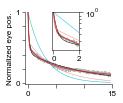

In [45]:
plt.figure(figsize=(1.5, 1.3))
plt.plot(sr_trange[1:], sr_data_conservative[1:]/sr_data_conservative[0], c=[0.7,]*3,lw=1)

lws = [0.5, 0.5, 0.5, 0.75]
colors = ['C9', red_l3, 'k', 'C3']
for i in range(4):
    plt.plot(sr_trange_full, best_models_conservative_example[i,:], c=colors[i], lw=lws[i])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.ylabel('Normalized eye pos.',labelpad=2)
plt.subplots_adjust(left = 0.21, top = 0.95, bottom=0.18, right=0.98)

ax.set_yticks(np.linspace(0, 1, 6))
ax.set_yticklabels([0, '', '', '', '', 1])
plt.ylim([-0.02, 1])
plt.xlim([-0.5, np.ceil(sr_trange[-1])])

ax.set_xticks(np.linspace(0, np.ceil(sr_trange[-1]),4))
ax.set_xticklabels([0, '', '', int(np.ceil(sr_trange[-1]))])


# plt.figtext(0.95, 0.85, r'%d $\tau$ fit, $\tau < \infty$'%(n), color='C3', ha='right')
# plt.figtext(0.95, 0.75, r'%d $\tau$ fit, $\tau < 5$ s'%(n), color=red_l3, ha='right')
# plt.figtext(0.95, 0.65, r'2 $\tau$ fit', color='k', ha='right')
# plt.figtext(0.95, 0.55, r'1 $\tau$ fit', color='C9', ha='right')

ax1 = plt.axes([.4, .55, 0.25, .4])
plt.yscale('log')
plt.plot(sr_trange[1:t_final_example_full], sr_data_conservative[1:t_final_example_full]/sr_data_conservative[0], c=[0.7,]*3,lw=1)
for i in range(4):
    plt.plot(sr_trange_full[:t_final_example_full], best_models_conservative_example[i,:t_final_example_full], c=colors[i], lw=lws[i])


ax1.set_ylim([3e-1, 1])
ax1.set_xlim([-0.1, 2])
ax1.set_yticklabels([],minor=True)
ax1.yaxis.tick_right()

plt.subplots_adjust(left = 0.15, top = 0.95, bottom=0.18, right=0.95) #left = 0.21

# Calculate R^2 of fits

In [19]:
r2s = np.zeros((2, 9))

j = 0
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components[fish_name]
    n_conservative = best_num_components_conservative[fish_name]
    for trace_num in range(len(file_names[fish_num])):
        n_extrap = best_num_components_extrap[file_names[fish_num][trace_num]]
        # Import data
        sr_trange, sr_data = prepareStepResponse(file_names[fish_num][trace_num], num_components_extrap = n_extrap)

        # Import fit
        fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
        lls_original = fit_file_original['lls']
        fits_original = fit_file_original['fits']
        best_trace_ind = np.argmax(lls_original, axis=1)

        best_fit = fits_original[n-1, trace_num][best_trace_ind[n-1], :]
        best_model = fitting_functions.exponentialModel(sr_trange, best_fit)
        r2s[0,j] = R2(sr_data/sr_data[0], best_model)
        

        sr_trange_conservative, sr_data_conservative = prepareStepResponse(file_names[fish_num][trace_num],num_components_extrap = n_extrap, conservative=True)

        fit_file_conservative = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
        lls_conservative = fit_file_conservative['lls']
        fits_conservative = fit_file_conservative['fits']
        best_trace_ind_conservative = np.argmax(lls_conservative, axis=1)

        best_fit_conservative = fits_conservative[n_conservative-1, trace_num][best_trace_ind_conservative[n_conservative-1], :]

        best_model_conservative = fitting_functions.exponentialModel(sr_trange, best_fit_conservative)
        r2s[1,j] = R2(sr_data_conservative/sr_data_conservative[0], best_model_conservative)
        j+= 1

Mean and sd of R^2 of step response fits using best, conservative extrapolations:

In [20]:
np.mean(r2s, axis=1)

array([0.98172499, 0.98288232])

In [21]:
np.std(r2s, axis=1)

array([0.00712807, 0.00733547])

Restricting to larvae with 2 responses:

In [25]:
r2s = np.zeros((2, 3))

j = 0
for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    n = best_num_components[fish_name]
    n_conservative = best_num_components_conservative[fish_name]
    if len(file_names[fish_num])==1:
        continue
        
    sr_data_all = [[] for i in range(2)]
    best_models = [[] for i in range(2)]
    
    sr_data_all_conservative = [[] for i in range(2)]
    best_models_conservative = [[] for i in range(2)]
    for trace_num in range(len(file_names[fish_num])):
        n_extrap = best_num_components_extrap[file_names[fish_num][trace_num]]
        # Import data
        sr_trange, sr_data = prepareStepResponse(file_names[fish_num][trace_num], num_components_extrap = n_extrap)
        sr_data_all[trace_num] = sr_data/sr_data[0]
            
        # Import fit
        fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'.mat')
        lls_original = fit_file_original['lls']
        fits_original = fit_file_original['fits']
        best_trace_ind = np.argmax(lls_original, axis=1)

        best_fit = fits_original[n-1, trace_num][best_trace_ind[n-1], :]
        best_models[trace_num] = fitting_functions.exponentialModel(sr_trange, best_fit)
        

        sr_trange_conservative, sr_data_conservative = prepareStepResponse(file_names[fish_num][trace_num],num_components_extrap = n_extrap, conservative=True)
        sr_data_all_conservative[trace_num] = sr_data_conservative/sr_data_conservative[0]
        
        fit_file_conservative = sio.loadmat('fit/results/conservative/'+fish_name+'_conservative.mat')
        lls_conservative = fit_file_conservative['lls']
        fits_conservative = fit_file_conservative['fits']
        best_trace_ind_conservative = np.argmax(lls_conservative, axis=1)

        best_fit_conservative = fits_conservative[n_conservative-1, trace_num][best_trace_ind_conservative[n_conservative-1], :]

        best_models_conservative[trace_num] = fitting_functions.exponentialModel(sr_trange, best_fit_conservative)
    r2s[0,j] = R2(sr_data_all, best_models)
    r2s[1,j] = R2(sr_data_all_conservative, best_models_conservative)
    j+= 1

In [26]:
np.mean(r2s, axis=1)

array([0.98218131, 0.98324217])

In [27]:
np.std(r2s, axis=1)

array([0.00854862, 0.00858335])

# Bounded timeconstant fits

In [67]:
# Best extrapolations
mses_best_bounded = np.zeros((len(file_names), max_num_components))

# Conservative extrapolations
mses_conservative_bounded = np.zeros((len(file_names), max_num_components))

for fish_num in range(len(file_names)):
    fish_name = file_names[fish_num][0][:-5]
    
    fit_file_original = sio.loadmat('fit/results/best/'+fish_name+'_5s.mat')
    lls_original = fit_file_original['lls']
    fits_original = fit_file_original['fits']
    best_trace_inds = np.nanargmax(lls_original, axis=1)
    for j in range(max_num_components):
        for i in range(len(file_names[fish_num])):
            n_extrap = best_num_components_extrap[file_names[fish_num][i]]
            sr_trange, sr_data = prepareStepResponse(file_names[fish_num][i], num_components_extrap = n_extrap)
            best_fit = fits_original[j,i][best_trace_inds[j],:]
            sse_fit = np.sum((sr_data/sr_data[0] - fitting_functions.exponentialModel(sr_trange, best_fit))**2)
            mses_best_bounded[fish_num,j] += sse_fit/len(sr_trange)

    fit_file_conservative = sio.loadmat('fit/results/conservative/'+fish_name+'_5s_conservative.mat')
    lls_conservative = fit_file_conservative['lls']
    fits_conservative = fit_file_conservative['fits']
    best_trace_inds_conservative = np.nanargmax(lls_conservative, axis=1)
    for j in range(max_num_components):
        for i in range(len(file_names[fish_num])):
            n_extrap = best_num_components_extrap[file_names[fish_num][i]]
            sr_trange, sr_data = prepareStepResponse(file_names[fish_num][i], num_components_extrap = n_extrap, conservative=True)
            best_fit = fits_conservative[j,i][best_trace_inds_conservative[j],:]
            sse_fit = np.sum((sr_data/sr_data[0] - fitting_functions.exponentialModel(sr_trange, best_fit))**2)
            mses_conservative_bounded[fish_num,j] += sse_fit/len(sr_trange)

In [68]:
mse_ratio_best = mses_best_bounded/mses_best
mse_ratio_conservative = mses_conservative_bounded/mses_conservative

### Fold decrease in MSE for 3-component models

In [69]:
np.median(mse_ratio_best[:,2]), np.median(mse_ratio_conservative[:,2])

(47.71301434088137, 20.15744409514466)

Range for best extrapolation:

In [14]:
[np.min(mse_ratio_best[:,2]), np.max(mse_ratio_best[:,2])]

[3.055617203040992, 458.8282999925055]

Range for conservative extrapolation:

In [15]:
[np.min(mse_ratio_conservative[:,2]), np.max(mse_ratio_conservative[:,2])]

[1.3348220571289102, 356.0526894684784]

# Summary plant

In [10]:
fit_file_summary = sio.loadmat('plants/summary-plant/sr_fits.mat')
lls_summary = fit_file_summary['lls']
fits_summary = fit_file_summary['fits']
# sse_summary = fit_file_summary['sses']

In [11]:
all_traces = [ '090711e_0006', '090811c_0002','090811d_0002','090811d_0004',
                '091111a_0001', '091111a_0003', '091111c_0003', '091211a_0002', '091211a_0005']

In [36]:
# Best extrapolations
mses_best_summary = np.zeros( max_num_components )
best_trace_inds = np.argmax(lls_summary, axis=1)

for j in range(max_num_components):
    mse_temp = np.zeros(len(all_traces))
    
    for i in range(len(all_traces)):
        n = best_num_components_extrap[all_traces[i]]
        sr_trange, sr_data = prepareStepResponse(all_traces[i], num_components_extrap = n)

        best_fit = fits_summary[j,i][best_trace_inds[j],:]
        sse_fit = np.sum((sr_data/sr_data[0] - fitting_functions.exponentialModel(sr_trange, best_fit))**2)
        mse_temp[j] = sse_fit/len(sr_trange)
    mses_best_summary[j] = np.mean(mse_temp)

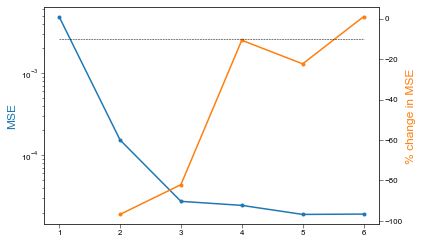

In [48]:
plt.yscale('log')
plt.plot(np.arange(1,7), mses_best_summary,'.-')
plt.ylabel('MSE', color='C0', fontsize=12);
ax = plt.twinx()
ax.plot(np.arange(2,7), (mses_best_summary[1:]-mses_best_summary[:-1])/mses_best_summary[:-1]*100,'.-', c='C1')
ax.plot([1, 6], [-10, -10], 'k--', lw=0.5)
plt.ylabel('% change in MSE', color='C1', fontsize=12);
plt.xticks(np.arange(1,7));

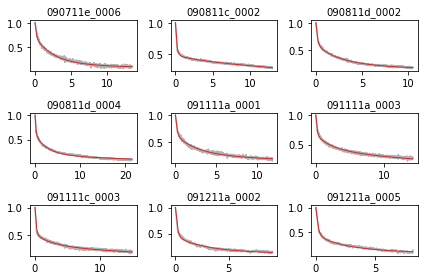

In [38]:
n_summary = 3
for i in range(len(all_traces)):
    plt.subplot(3,3,i+1)
    plt.title(all_traces[i],fontsize=10)
    n = best_num_components_extrap[all_traces[i]]
    sr_trange, sr_data = prepareStepResponse(all_traces[i], num_components_extrap = n)
    best_fit = fits_summary[n_summary-1,i][best_trace_inds[n_summary-1],:]
    plt.plot(sr_trange, sr_data/sr_data[0], c=(0.7,)*3)
    plt.plot(sr_trange, fitting_functions.exponentialModel(sr_trange, best_fit), lw=1, c='C3')
plt.tight_layout()